In [ ]:
import pandas as pd
reviews = pd.read_csv("balancedYelpReviews.csv")
reviews = reviews[["reviewContent"]]
reviews = reviews[reviews["reviewContent"].str.split().str.len() >= 3]

print(reviews.head())

                                       reviewContent
0  MOjitos =)  MOJItos =)  MOJITOS =)   Good and ...
1  I know this place is run by the Cheesecake Fac...
2  Awesome food - margaritas to die for!  I got t...
3  Outstanding!  We had the regular burger becaus...
4  We stopped in for an early dinner on Sunday.  ...


In [ ]:
import torch
from transformers import pipeline
from tqdm import tqdm
import re

# We're using DistilBERT as it's smaller, faster, and ideal for classification
print("Loading classification model...")
classifier = pipeline(
    "text-classification",
    model="distilbert-base-uncased-finetuned-sst-2-english",  #model understands text quality
    device=0 if torch.cuda.is_available() else -1
)

print("Model loaded successfully!")

# Step 4: Create our classification function
def classify_review_with_bert(review_text):
    """
    Classify a single review using BERT + rule-based approach
    Returns: dict with isPromotional, isIrrelevant, notVisited, justification
    """

    review_lower = review_text.lower().strip()

    is_promotional = 0
    is_irrelevant = 0
    not_visited = 0
    justification = "No violations"

    # Rule 1: Check for PROMOTIONAL content
    promo_keywords = [
        'discount', 'coupon', 'promo', 'sale', 'deal', 'offer',
        'www.', 'http', '.com', 'click here', 'visit our',
        'buy now', 'order now', 'call us', 'follow us on',
        'free shipping', 'limited time', '% off'
    ]

    if any(keyword in review_lower for keyword in promo_keywords):
        is_promotional = 1
        justification = "Contains promotional content or links"
        return {
            "ispromotional": is_promotional,
            "isirrelevant": is_irrelevant,
            "notvisited": not_visited,
            "justification": justification
        }

    # Rule 2: Check for NOT VISITED
    not_visited_phrases = [
        "haven't been", "never been", "haven't visited", "never visited",
        "planning to go", "want to try", "heard about", "from what i hear",
        "haven't tried", "never tried", "based on photos", "looks like",
        "seems like", "appears to", "planning to visit", "hope to visit"
    ]

    if any(phrase in review_lower for phrase in not_visited_phrases):
        not_visited = 1
        justification = "Reviewer hasn't actually visited the business"
        return {
            "ispromotional": is_promotional,
            "isirrelevant": is_irrelevant,
            "notvisited": not_visited,
            "justification": justification
        }

    # Rule 3: Check for IRRELEVANT content using BERT
    try:
        sentiment_result = classifier(review_text[:512])  # BERT has 512 token limit
        confidence = sentiment_result[0]['score']

        # If BERT is very uncertain, the text might be irrelevant/nonsensical
        if confidence < 0.6:  # Low confidence suggests unclear text
            is_irrelevant = 1
            justification = "Review content appears unclear or irrelevant"
    except:
        pass  # If BERT fails, just skip this check

    return {
        "ispromotional": is_promotional,
        "isirrelevant": is_irrelevant,
        "notvisited": not_visited,
        "justification": justification
    }

# Function to process your entire DataFrame
def add_classification_columns(df, review_column="reviewContent"):

    print(f"Processing {len(df)} reviews...")

    df["ispromotional"] = 0
    df["isirrelevant"] = 0
    df["notvisited"] = 0
    df["justification"] = ""

    # Process each review
    for i, row in tqdm(df.iterrows(), total=len(df), desc="Classifying reviews"):
        try:
            review_text = str(row[review_column])

            # Skip empty reviews
            if pd.isna(review_text) or len(review_text.strip()) < 3:
                df.at[i, "isirrelevant"] = 1
                df.at[i, "justification"] = "Empty or missing review"
                continue

            # Classify the review
            result = classify_review_with_bert(review_text)

            # Update the DataFrame
            df.at[i, "ispromotional"] = result["ispromotional"]
            df.at[i, "isirrelevant"] = result["isirrelevant"]
            df.at[i, "notvisited"] = result["notvisited"]
            df.at[i, "justification"] = result["justification"]

        except Exception as e:
            print(f"Error at row {i}: {e}")
            df.at[i, "justification"] = "Processing error"
            continue

    return df

Loading classification model...


Device set to use cpu


Model loaded successfully!


In [ ]:
reviews_classified = add_classification_columns(reviews)

Processing 1995 reviews...


Classifying reviews: 100%|██████████| 1995/1995 [05:04<00:00,  6.55it/s]


In [ ]:
reviews_classified

,reviewContent,isPromotional,isIrrelevant,notVisited,justification
0,MOjitos =) MOJItos =) MOJITOS =) Good and ...,0,0,0,No violations
1,I know this place is run by the Cheesecake Fac...,1,0,0,Contains promotional content or links
2,Awesome food - margaritas to die for! I got t...,0,0,0,No violations
3,Outstanding! We had the regular burger becaus...,0,0,0,No violations
4,We stopped in for an early dinner on Sunday. ...,0,0,0,No violations
...,...,...,...,...,...
1995,WTF do you mean I'm getting in line for 20 min...,0,0,0,No violations
1996,"Excellent drinks, laid back vibe, great music ...",0,0,0,No violations
1997,This place is worth the wait ! Everything is d...,0,0,0,No violations
1998,It's not a myth - this place absolutely serves...,0,0,0,No violations


In [ ]:
reviews2 = pd.read_csv("reviews - All Reviews Labelled.csv")
reviews2 = reviews2[["description", "ispromotional", "isirrelevant", "notvisited"]]
reviews2_edited = reviews2[["description"]]
reviews2_edited = reviews2_edited.rename(columns={"description": "reviewContent"})
reviews2_edited_classified = add_classification_columns(reviews2_edited)


Processing 675 reviews...


Classifying reviews: 100%|██████████| 675/675 [01:48<00:00,  6.20it/s]


In [ ]:
reviews2_edited_classified.head(10)

,reviewContent,ispromotional,isirrelevant,notvisited,justification
0,{'en': 'very crowded here but i got served pre...,0,0,0,No violations
1,{'en': 'This was probably one of the oldest Ch...,0,0,0,No violations
2,{'en': 'A must visit desert place in Singapore...,0,0,0,No violations
3,{'en': 'Dumpling Darlings is one of my ✨favour...,0,0,0,No violations
4,"{'en': ""Brought my parents here for a nice nig...",0,0,0,No violations
5,{'en': 'Absolutely delicious new eatery that’s...,0,0,0,No violations
6,{'en': 'Small place tucked along Amoy street. ...,0,0,0,No violations
7,{'en': 'GREAT experience here! Ordered the bra...,0,1,0,Review content appears unclear or irrelevant
8,"{'en': 'The dumplings are great, especially th...",0,0,0,No violations
9,{'en': 'Fantastic place for Hong Kong style du...,0,0,0,No violations


Promotional Accuracy: 620/675 = 0.919 (91.9%)
Irrelevant Accuracy:  663/675 = 0.982 (98.2%)
Not Visited Accuracy: 666/675 = 0.987 (98.7%)


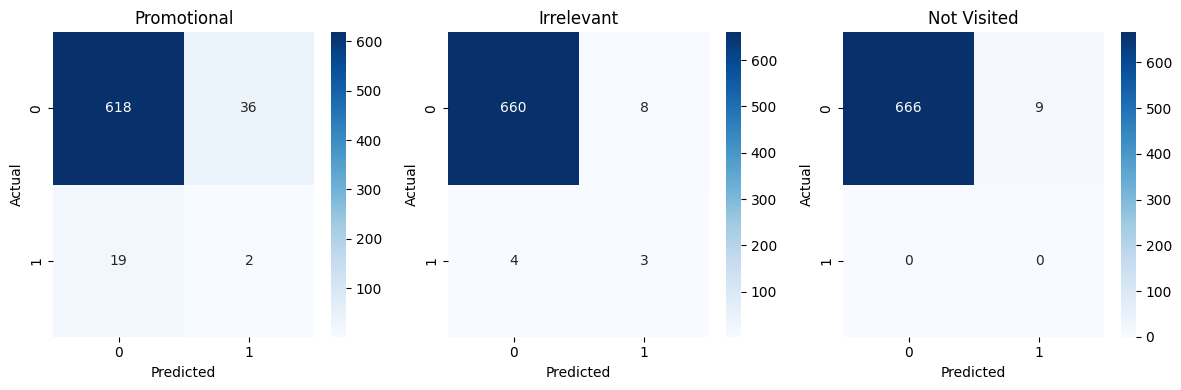

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

true_promotional = reviews2['ispromotional'].values
true_irrelevant = reviews2['isirrelevant'].values
true_not_visited = reviews2['notvisited'].values

pred_promotional = reviews2_edited_classified['ispromotional'].values
pred_irrelevant = reviews2_edited_classified['isirrelevant'].values
pred_not_visited = reviews2_edited_classified['notvisited'].values

# Calculate accuracy for each category
promo_correct = (true_promotional == pred_promotional).sum()
promo_total = len(true_promotional)
promo_accuracy = promo_correct / promo_total

irrelevant_correct = (true_irrelevant == pred_irrelevant).sum()
irrelevant_total = len(true_irrelevant)
irrelevant_accuracy = irrelevant_correct / irrelevant_total

not_visited_correct = (true_not_visited == pred_not_visited).sum()
not_visited_total = len(true_not_visited)
not_visited_accuracy = not_visited_correct / not_visited_total

print(f"Promotional Accuracy: {promo_correct}/{promo_total} = {promo_accuracy:.3f} ({promo_accuracy*100:.1f}%)")
print(f"Irrelevant Accuracy:  {irrelevant_correct}/{irrelevant_total} = {irrelevant_accuracy:.3f} ({irrelevant_accuracy*100:.1f}%)")
print(f"Not Visited Accuracy: {not_visited_correct}/{not_visited_total} = {not_visited_accuracy:.3f} ({not_visited_accuracy*100:.1f}%)")

# Overall accuracy
all_correct = (
    (true_promotional == pred_promotional) &
    (true_irrelevant == pred_irrelevant) &
    (true_not_visited == pred_not_visited)
).sum()

overall_accuracy = all_correct / len(reviews2)


# Create confusion matrices
cm_promo = confusion_matrix(true_promotional, pred_promotional)
cm_irrelevant = confusion_matrix(true_irrelevant, pred_irrelevant)
cm_notvisited = confusion_matrix(true_not_visited, pred_not_visited)

# A quick visualization
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot each confusion matrix
sns.heatmap(cm_promo, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Promotional')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_irrelevant, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Irrelevant')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

sns.heatmap(cm_notvisited, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Not Visited')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()
